In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random

#tensorflow keras imports
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [4]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [70]:
if (True):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    mu_t2 = 0.
    sd_m = 0.
    sd_t = 0.
    sd_t2 = 0.
    
    mj1_list = []
    mj2_list = []

    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qq in ['qq','qqq']:

                print("on ...",m1,m2,qq)

                ltau1_m_m = []
                ltau2_m_m = []
                ltau3_m_m = []
                stau1_m_m = []
                stau2_m_m = []
                stau3_m_m = []
                if (m1>0 and m2>0):
                    myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    if (qq=='qqq'):
                        myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qqq/LHCO_RnD_qqq2_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    jets_m_m = []
                    for line in myfile:
                        jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                        pass
                    ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                    sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                    lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                    smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.
                    
                    #check ordering of the leading and subleading jets
                    #if leading jet mm > subleading, continue
                    #if leading jet mm < subleading, swap
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]

                    ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    ltau3_m_m = np.array([float(ljet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    stau3_m_m = np.array([float(sjet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    mjj = computemjj_txt(jets_m_m)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]
                    pass
                elif m1==0 and m2==0:
                    df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                    lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                    smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                    
                    #check jet ordering
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                    ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                    ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                    ltau3_m_m = np.array(df_QCD[["tau3j1"]]).flatten()
                    stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                    stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                    stau3_m_m = np.array(df_QCD[["tau3j2"]]).flatten()
                    mjj = computemjj_pd(df_QCD)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]

                    mu_m = np.mean(lmass_m_m)
                    mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                    mu_t2 = np.mean(ltau3_m_m/(ltau2_m_m+0.0001))
                    sd_m = np.std(lmass_m_m)
                    sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                    sd_t2 = np.std(ltau3_m_m/(ltau2_m_m+0.0001))
                    pass
                else:
                    continue

                ms = np.stack([lmass_m_m,smass_m_m],axis=1)
                ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
                ts2 = np.stack([ltau3_m_m/(ltau2_m_m+0.0001),stau3_m_m/(stau2_m_m+0.001)],axis=1)
                order1 = [np.argmax(ms[i]) for i in range(len(ms))]
                order2 = [np.argmin(ms[i]) for i in range(len(ms))]
                mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
                mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
                
                mj1_list.append(mJ1)
                mj2_list.append(mJ2)
                x[m1,m2,qq] = np.stack([(mJ2 - mu_m)/sd_m,
                                        ((mJ1 - mJ2) - mu_m)/sd_m,
                                        ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                        ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                        ([ts2[i][order2[i]] for i in range(len(ts2))] - mu_t2)/sd_t2,
                                        ([ts2[i][order1[i]] for i in range(len(ts2))] - mu_t2)/sd_t2],axis=1)
                lmass_vec[m1,m2]=lmass_m_m
                pass
            pass
        pass
    
    x_array = []
    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array+=[x[m1,m2,qq]]
                
    x_array_qqq = []
    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qqq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array_qqq+=[x[m1,m2,qqq]]
    # np.save("x_array_qq",x_array)
    # np.save("x_array_qqq",x_array_qqq)

on ... 0 0 qq
on ... 0 0 qqq
on ... 0 0.5 qq
on ... 0 0.5 qqq
on ... 0 1 qq
on ... 0 1 qqq
on ... 0 1.5 qq
on ... 0 1.5 qqq
on ... 0 2 qq
on ... 0 2 qqq
on ... 0 2.5 qq
on ... 0 2.5 qqq
on ... 0 3 qq
on ... 0 3 qqq
on ... 0 3.5 qq
on ... 0 3.5 qqq
on ... 0 4 qq
on ... 0 4 qqq
on ... 0 4.5 qq
on ... 0 4.5 qqq
on ... 0 5 qq
on ... 0 5 qqq
on ... 0 5.5 qq
on ... 0 5.5 qqq
on ... 0 6 qq
on ... 0 6 qqq
on ... 0.5 0 qq
on ... 0.5 0 qqq
on ... 0.5 0.5 qq
on ... 0.5 0.5 qqq
on ... 0.5 1 qq
on ... 0.5 1 qqq
on ... 0.5 1.5 qq
on ... 0.5 1.5 qqq
on ... 0.5 2 qq
on ... 0.5 2 qqq
on ... 0.5 2.5 qq
on ... 0.5 2.5 qqq
on ... 0.5 3 qq
on ... 0.5 3 qqq
on ... 0.5 3.5 qq
on ... 0.5 3.5 qqq
on ... 0.5 4 qq
on ... 0.5 4 qqq
on ... 0.5 4.5 qq
on ... 0.5 4.5 qqq
on ... 0.5 5 qq
on ... 0.5 5 qqq
on ... 0.5 5.5 qq
on ... 0.5 5.5 qqq
on ... 0.5 6 qq
on ... 0.5 6 qqq
on ... 1 0 qq
on ... 1 0 qqq
on ... 1 0.5 qq
on ... 1 0.5 qqq
on ... 1 1 qq
on ... 1 1 qqq
on ... 1 1.5 qq
on ... 1 1.5 qqq
on ... 1 2 qq
on ... 1

In [74]:
count = 0
for i in range(len(mj1_list)):
    if mj1_list[3][i] > mj2_list[4][i]:
        #print("greater")
        count+=1
print(f"{count} instances of mj1 > mj2")

204 instances of mj1 > mj2


In [56]:
x = {}
x_array_read = np.load("x_array_qq.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for qq in ['qq','qqq']:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            mycounter+=1
            x[m1,m2,qq] = x_array_read[mycounter]
            
x_array_read = np.load("x_array_qqq.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for qqq in ['qq','qqq']:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            mycounter+=1
            x[m1,m2,qqq] = x_array_read[mycounter]

In [76]:
np.shape(x[0,0, qq])

(121352, 6)

In [58]:
np.shape(x[0,0, qqq])

(121352, 6)

In [59]:
x_vals_qq = np.load("x_vals_qq.npy")
y_vals_qq = np.load("y_vals_qq.npy")

In [10]:
np.shape(y_vals_qq)

(27249420,)

In [10]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_vals_qq, y_vals_qq, test_size=0.5)

In [84]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_qq = Sequential()
model_qq.add(Dense(256, input_dim=8, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_qq.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_qq = model_qq.fit(X_train_qq, Y_train_qq, epochs=5000,validation_data=(X_val_qq, Y_val_qq),batch_size=5*1024,callbacks=[es])

plt.plot(myhistory_qq.history['val_loss'][1:])
plt.plot(myhistory_qq.history['loss'][1:])

Epoch 1/5000
2662/2662 [==============================] - 27s 10ms/step - loss: 0.2587 - accuracy: 0.8976 - val_loss: 0.2046 - val_accuracy: 0.9232
Epoch 2/5000
2662/2662 [==============================] - 27s 10ms/step - loss: 0.1937 - accuracy: 0.9267 - val_loss: 0.1833 - val_accuracy: 0.9298
Epoch 3/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1778 - accuracy: 0.9316 - val_loss: 0.1716 - val_accuracy: 0.9336
Epoch 4/5000
2662/2662 [==============================] - 27s 10ms/step - loss: 0.1687 - accuracy: 0.9346 - val_loss: 0.1650 - val_accuracy: 0.9359
Epoch 5/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1632 - accuracy: 0.9367 - val_loss: 0.1604 - val_accuracy: 0.9377
Epoch 6/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1593 - accuracy: 0.9383 - val_loss: 0.1571 - val_accuracy: 0.9391
Epoch 7/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1563 - accuracy: 0.9395 - val_

KeyboardInterrupt: 

In [85]:
#model_qq.save('model_qq_v2')

INFO:tensorflow:Assets written to: model_qq_v2/assets


In [11]:
model_qq = tf.keras.models.load_model("model_qq_v2")

2023-12-03 23:10:05.501211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 23:10:06.260759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37803 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [93]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt

qq = 'qq'

xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []

#for sigfrac in np.logspace(-3,-1,20):
    #print(sigfrac)
sigfrac = 0.1

w1 = 0.5
w2 = 0.5
# if (sigfrac > 0.5):
#     continue

for l in model_qq.layers:
    l.trainable=False

inputs_hold = tf.keras.Input(shape=(1,))
simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(2.))(inputs_hold)
model3 = Model(inputs = inputs_hold, outputs = simple_model)

inputs_hold2 = tf.keras.Input(shape=(1,))
simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(5.))(inputs_hold2)
model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

inputs_hold3 = tf.keras.Input(shape=(1,))
simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

inputs = tf.keras.Input(shape=(6,))
inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_qq(inputs2)
LLR = hidden_layer_1 / (1.-hidden_layer_1)
#LLR_xs = 1.+sigfrac*LLR - sigfrac
LLR_xs = 1 + model33(tf.ones_like(inputs)[:,0])*LLR
ws = LLR_xs / (1.+LLR_xs+0.0001)
model_all2 = Model(inputs = inputs, outputs = ws)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

m1 = 6
m2 = 6

test_background = int(1/2 *len(x[0,0, qq]))
train_background = int(1/4 * len(x[0,0,qq]))
train_data = int(1/4 * len(x[0,0,qq]))
train_reference = int(1/4 * len(x[0,0,qq]))
#signal
test_signal_length = int(1/2*len(x[m1,m2,qq]))
sig_frac = sigfrac

N = int(1/4 * len(x[0,0,qq]))
signal = x[m1,m2,qq][test_signal_length:test_signal_length+int(sig_frac*N)]

x_vals_ = np.concatenate([x[0,0,qq][test_background:],signal])
y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

print(N,len(x[0,0,qq])-N,len(x[m1,m2,qq][0:int(sig_frac*N)]),len(x[m1,m2,qq][0:int(sig_frac*N)])/N)

X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)
print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
xx+=[sigfrac]
yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
scores = model_all2.predict(np.concatenate([x[0,0,qq][0:test_background],x[m1,m2,qq][0:test_signal_length]]),batch_size=1024)
y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
fpr, tpr, _ = metrics.roc_curve(y, scores)    

#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=6, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)

#     scores2 = model_cwola.predict(np.concatenate([x[0,0,qq][0:test_background],x[m1,m2,qq][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr+0.0001))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2+0.0001))

#     msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
#     msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]

30338 91014 3033 0.09997363043048323
Epoch 1/20
32/32 [==============================] - 1s 11ms/step - loss: 0.6953 - val_loss: 0.6947
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6932 - val_loss: 0.6923
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6903 - val_loss: 0.6889
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6865 - val_loss: 0.6862
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6841 - val_loss: 0.6845
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6824 - val_loss: 0.6830
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6808 - val_loss: 0.6812
Epoch 8/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6796 - val_loss: 0.6799
Epoch 9/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6786 - val_loss: 0.6786
Epoch 10/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6776 

(0.0, 700.0)

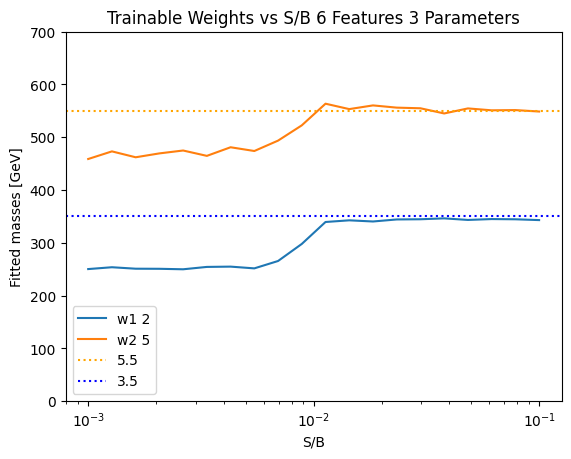

In [32]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs S/B 6 Features 3 Parameters")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

Text(0, 0.5, 'Max SIC')

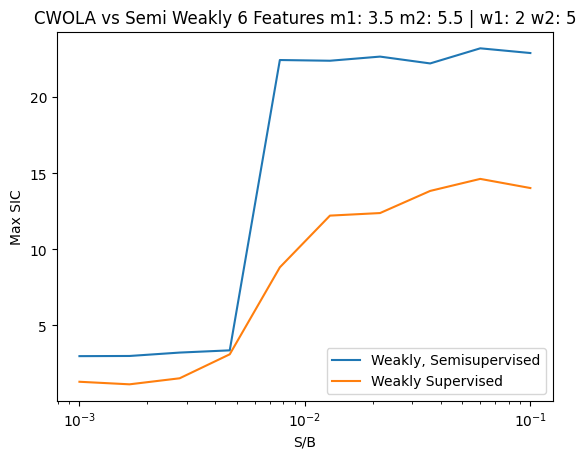

In [88]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly 6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2}")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

0.001
30338 91014 30 0.0009888588568791614
3.5 5.5 2.5061605 4.598825
92/92 [==============================] - 0s 652us/step
0.0012742749857031334
30338 91014 38 0.0012525545520469378
3.5 5.5 2.5310028 4.740749
92/92 [==============================] - 0s 679us/step
0.001623776739188721
30338 91014 49 0.0016151361329026304
3.5 5.5 2.5325208 4.636435
92/92 [==============================] - 0s 686us/step
0.00206913808111479
30338 91014 62 0.002043641637550267
3.5 5.5 2.510254 4.69403
92/92 [==============================] - 0s 687us/step
0.0026366508987303583
30338 91014 79 0.002603994989781792
3.5 5.5 2.4961245 4.7436614
92/92 [==============================] - 0s 639us/step
0.003359818286283781
30338 91014 101 0.003329158151493177
3.5 5.5 2.5442936 4.6543307
92/92 [==============================] - 0s 675us/step
0.004281332398719396
30338 91014 129 0.004252093084580394
3.5 5.5 2.5294049 4.785524
92/92 [==============================] - 1s 669us/step
0.00545559478116852
30338 91014 165 

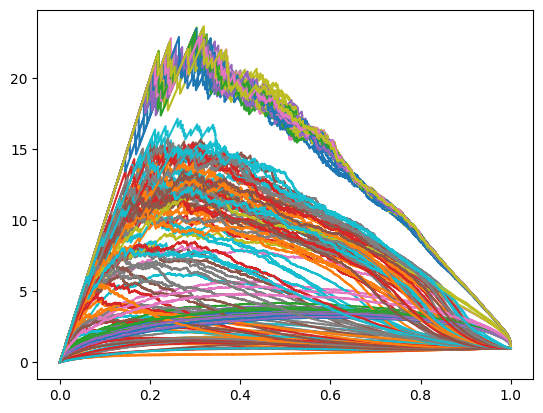

In [20]:
msic1_runs = []
msic2_runs = []
initial_weights_list_runs = []
ww_runs = []

num_runs = 5

for _ in range(num_runs):
    
    qq = 'qq'

    xx = []
    yy = []
    zz = []
    ww = []

    msic1 = []
    msic2 = []

    for sigfrac in np.logspace(-3,-1,20):
        print(sigfrac)
        #sigfrac = 0.05

        w1 = 2
        w2 = 5
        if (sigfrac > 0.5):
            continue

        for l in model_qq.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(2.))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(5.))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(6,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_qq(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1)
        #LLR_xs = 1.+sigfrac*LLR - sigfrac
        LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
        ws = LLR_xs / (1.+LLR_xs+0.0001)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 3.5
        m2 = 5.5

        test_background = int(1/2 *len(x[0,0, qq]))
        train_background = int(1/4 * len(x[0,0,qq]))
        train_data = int(1/4 * len(x[0,0,qq]))
        train_reference = int(1/4 * len(x[0,0,qq]))
        #signal
        test_signal_length = int(1/2*len(x[m1,m2,qq]))
        sig_frac = sigfrac

        #randomize signal events
        random_test_signal_length = random.randint(0, test_signal_length - 1)
        N = int(1/4 * (len(x[0,0,qq])))
        signal = x[m1, m2,qq][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

        x_vals_ = np.concatenate([x[0,0,qq][test_background:],signal])
        y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

        print(N,len(x[0,0,qq])-N,len(x[m1,m2,qq][0:int(sig_frac*N)]),len(x[m1,m2,qq][0:int(sig_frac*N)])/N)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        xx+=[sigfrac]
        yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
        zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
        ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0,qq][0:test_background],x[m1,m2,qq][0:test_signal_length]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)    

        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=6, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0,qq][0:test_background],x[m1,m2,qq][0:test_signal_length]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        plt.plot(tpr,tpr/np.sqrt(fpr+0.0001))
        plt.plot(tpr2,tpr2/np.sqrt(fpr2+0.0001))

        msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
        msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]
        
    msic1_runs.append(msic1)
    msic2_runs.append(msic2)
    ww_runs.append(ww)

Text(0, 0.5, 'Avg Max SIC')

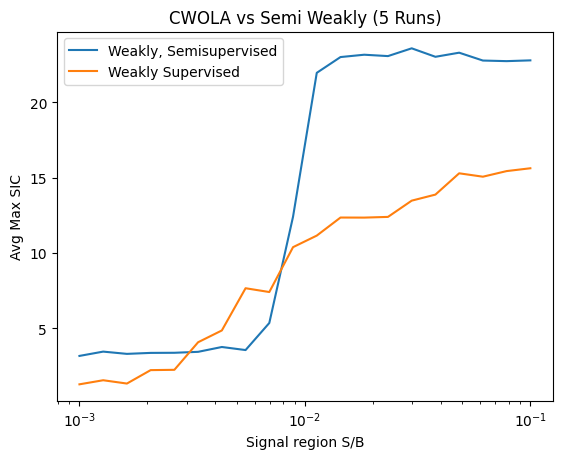

In [23]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

plt.plot(xx,avgmsic1,label="Weakly, Semisupervised")
plt.plot(xx,avgmsic2,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly ({num_runs} Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

Text(0, 0.5, 'Avg Max SIC')

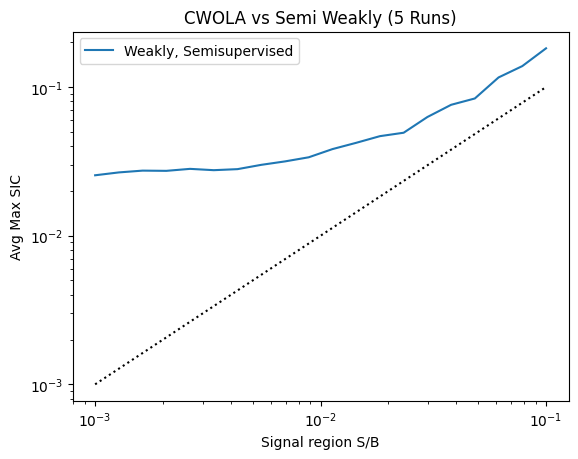

In [31]:
avgww = np.median(ww_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

plt.plot(xx,avgww,label="Weakly, Semisupervised")
plt.plot(xx,xx,ls=":",color="black")

plt.title(f"CWOLA vs Semi Weakly ({num_runs} Runs)")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

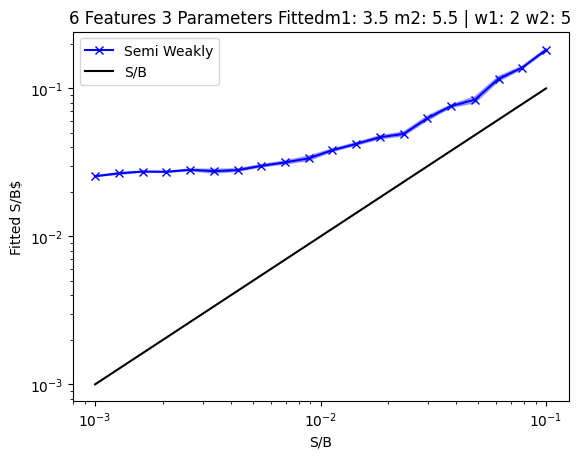

In [45]:
signal_fraction_values = np.logspace(-3, -1, 20)

fittedw = avgww
fittedwstd = np.std(ww_runs, axis = 0)

plt.plot(signal_fraction_values, fittedw, marker = "x", label='Semi Weakly', color='blue')
plt.plot(xx, xx, marker = "", label='S/B', color='black')

plt.fill_between(signal_fraction_values, fittedw - fittedwstd, fittedw + fittedwstd, color='blue', alpha=0.3, hatch = "//")

plt.xlabel('S/B')

plt.ylabel(r'Fitted S/B$')
plt.title(f'6 Features 3 Parameters Fittedm1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

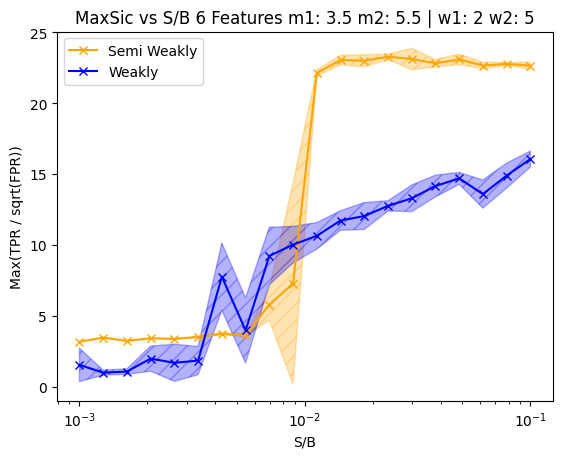

In [18]:
signal_fraction_values = np.logspace(-3, -1, 20)

maxsic1 = avgmsic1
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = msicstds1

maxsic2 = avgmsic2
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = msicstds2

plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")

plt.xlabel('S/B')

plt.rc('text', usetex=True)
plt.ylabel(r'Max$\left(\frac{TPR}{\sqrt{FPR}}\right)$')
plt.title(f'6 Features 3 Parameters m1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.xscale("log")
plt.legend()
plt.show()

Text(0, 0.5, 'Fitted S/B')

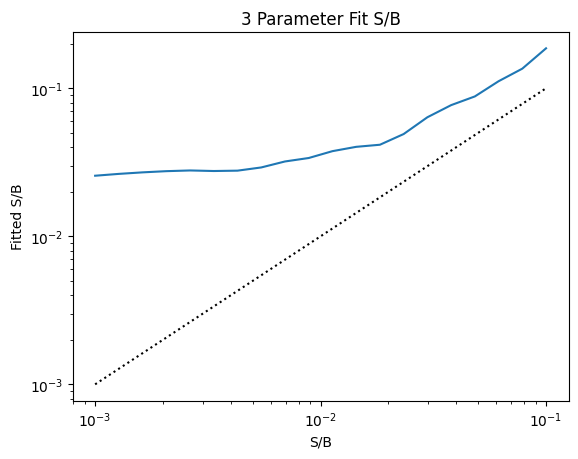

In [19]:
plt.plot(xx,np.array(ww))
plt.xscale("log")
plt.yscale("log")
plt.plot(xx,xx,ls=":",color="black")
plt.title("3 Parameter Fit S/B")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")

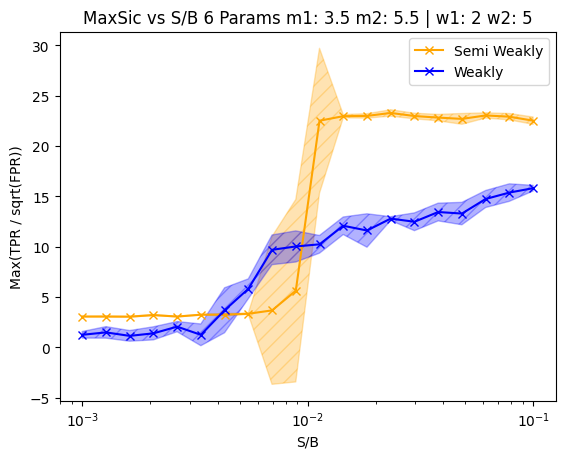

In [93]:
signal_fraction_values = np.logspace(-3, -1, 20)

maxsic1 = avgmsic1
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = msicstds1

maxsic2 = avgmsic2
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = msicstds2

plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")

plt.xlabel('S/B')
plt.ylabel('Max(TPR / sqrt(FPR))')
plt.title(f'MaxSic vs S/B 6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.xscale("log")
plt.legend()
plt.show()

Text(0, 0.5, 'Avg Max SIC')

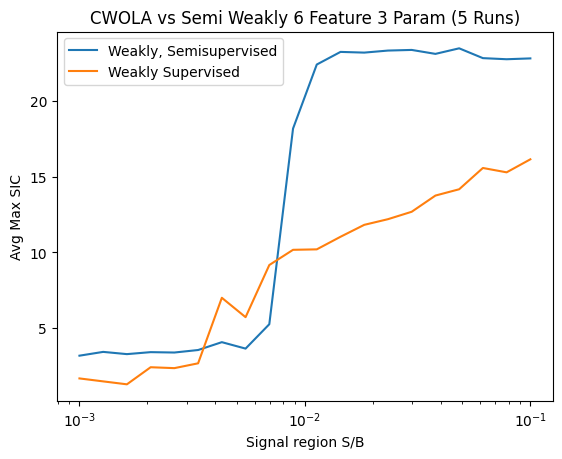

In [95]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

plt.plot(xx,avgmsic1,label="Weakly, Semisupervised")
plt.plot(xx,avgmsic2,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly 6 Feature 3 Param ({num_runs} Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

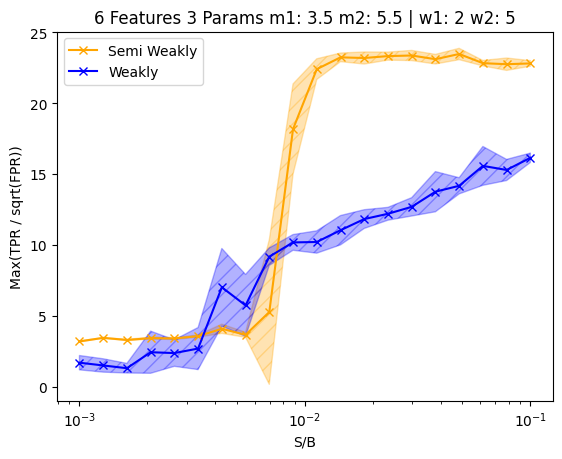

In [96]:
signal_fraction_values = np.logspace(-3, -1, 20)

maxsic1 = avgmsic1
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = msicstds1

maxsic2 = avgmsic2
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = msicstds2

plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")

plt.xlabel('S/B')
plt.ylabel('Max(TPR / sqrt(FPR))')
plt.title(f'6 Features 3 Params m1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.xscale("log")
plt.legend()
plt.show()

Text(0, 0.5, 'Fitted S/B')

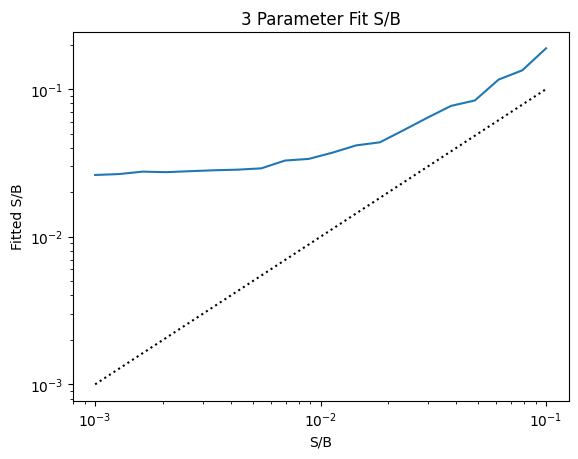

In [97]:
plt.plot(xx,np.array(ww))
plt.xscale("log")
plt.yscale("log")
plt.plot(xx,xx,ls=":",color="black")
plt.title("3 Parameter Fit S/B")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")

In [152]:
mass_range = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

In [188]:
def create_loss_landscape_6Features(model, m1, m2):
    
    Nfeatures = 6
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"z_allm1m2_{Nfeatures}FeaturesHD.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(filename, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
    #varying sigfrac, fixed mass pair
    
    losses_list = []

    epsilon = 1e-6
    sig_space = np.logspace(-3, -1, 20)
    sig_space = [sig_space[15]]
    
    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)
    
    for sig in sig_space:
        print("Signal Fraction: ", sig)
        #print(w1, w2)
        for w1 in weight_list:
            for w2 in weight_list:
                sigfrac = sig

                for l in model.layers:
                    l.trainable=False

                inputs_hold = tf.keras.Input(shape=(1,))
                simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
                model3 = Model(inputs = inputs_hold, outputs = simple_model)

                inputs_hold2 = tf.keras.Input(shape=(1,))
                simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
                model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(Nfeatures,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                LLR_xs = 1.+sigfrac*LLR - sigfrac
                #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
                ws = LLR_xs / (1.+LLR_xs+0.0001)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                
                key = (sigfrac,m1,m2)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0, qq]))
                train_background = int(1/4 * len(x[0,0,qq]))
                train_data = int(1/4 * len(x[0,0,qq]))
                train_reference = int(1/4 * len(x[0,0,qq]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq]))
                sig_frac = sigfrac

                #randomize signal events
                #random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0,qq])))
                signal = x[m1, m2,qq][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_vals_ = np.concatenate([x[0,0,qq][test_background:],signal])
                y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

                loss = model_all2.evaluate(x_vals_, y_vals_, verbose = 0)
                losses_list.append(loss)
                
        if key in z:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z[sigfrac, m1, m2] = losses_list
            losses_list = []
            np.save(filename, z)

In [ ]:
create_loss_landscape_6Features(model_qq, 3, 4.5)

Dictionary doesn't exist, creating one...
Signal Fraction:  0.0379269019073225


In [121]:
z_allm1m2 = np.load("z_allm1m2_6Features.npy", allow_pickle = True).item()
z_allm1m2.keys()

dict_keys([(0.001, 3, 4.5), (0.0012742749857031334, 3, 4.5), (0.001623776739188721, 3, 4.5), (0.00206913808111479, 3, 4.5), (0.0026366508987303583, 3, 4.5), (0.003359818286283781, 3, 4.5), (0.004281332398719396, 3, 4.5), (0.00545559478116852, 3, 4.5), (0.0069519279617756054, 3, 4.5), (0.008858667904100823, 3, 4.5), (0.011288378916846888, 3, 4.5), (0.01438449888287663, 3, 4.5), (0.018329807108324356, 3, 4.5), (0.023357214690901212, 3, 4.5), (0.029763514416313176, 3, 4.5), (0.0379269019073225, 3, 4.5), (0.04832930238571752, 3, 4.5), (0.06158482110660261, 3, 4.5), (0.07847599703514611, 3, 4.5), (0.1, 3, 4.5)])

In [111]:
def create_gif_nofit(m1, m2, z):
    
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    sig_space = np.logspace(-3, -1 , 20)
    
    frames = []
    for sb in sig_space:
    
        loss_landscape_2D_nofit(sb, m1, m2, z)

        image_path = os.path.join(output_directory, f'hist_{sigfrac}.png')
        plt.savefig(image_path)
        plt.close()
        clear_output(wait=True)

        # Append the image to the frames list
        frames.append(Image.open(image_path))

    # Create the final GIF that combines all frames
    output_gif_filename = f'sigspace{m1}{m2}fixed.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=400, loop=0)

In [123]:
create_gif_nofit(3, 4.5, z_allm1m2)

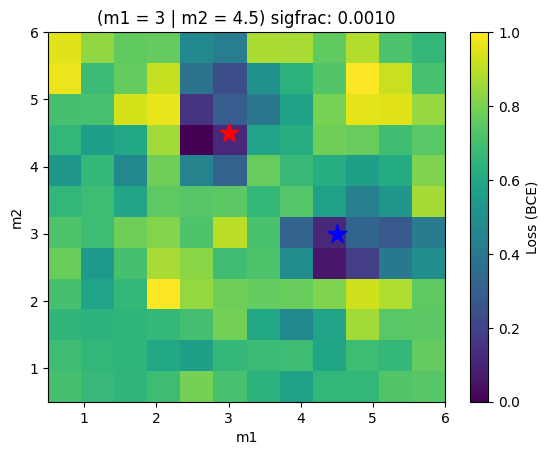

In [151]:
loss_landscape_nofit(0.001, 3, 4.5, z_allm1m2);

In [186]:
def loss_landscape_nofit(sigfrac, m1, m2, z):
    
    #create grid of points for the model to be evaluated at
    #current resolutionis 12 * 12 = 144
    
    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)
    
    grid_axes = []
    for w1 in weight_list:
        for w2 in weight_list:
            grid_axes.append((w1, w2))
            
    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(z[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(w1_values, w2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.colorbar(label='Loss (BCE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('(m1 = {} | m2 = {}) sigfrac: {:.4f}'.format(m1, m2, sigfrac))
    return h